# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [118]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [119]:
# Load Data 
data = pd.read_csv("assignment2_data.csv",index_col=0)
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


### 전처리

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


In [121]:
# 결측치 존재 확인
data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [122]:
# New_Price는 6019 중 5195개의 데이터가 결측치이므로 제거 
data.drop(["New_Price"], axis=1, inplace=True)

In [123]:
# Mileage,Engine,Power단위 제거
data['Mileage'] = data['Mileage'].apply(lambda x: float(str(x).split()[0]))
data['Engine'] = data['Engine'].apply(lambda x: float(str(x).split()[0]))
data['Power'] = data['Power'].apply(lambda x: str(x).split()[0])

In [124]:
# Power 컬럼만 따로 함수 처리 ( 결측치 str로 변환 불가 에러 )
data=data[data['Power'].notna()]
data=data[data['Power']!='null']

In [125]:
# 결측치 평균으로 대체
data = data.dropna()

In [126]:
# Mileage,Engine,Power,Seats타입 변경
data[['Mileage','Engine','Power']] = data[['Mileage','Engine','Power']].astype('float')
data['Seats'] = pd.to_numeric(data['Seats']).astype('category')

In [127]:
# 타입 변경에 따라 다시 결측치 발생해 처리
data=data[data['Power'].notna()]

In [128]:
# 결측치 존재 확인
data.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

In [129]:
# 중복치 존재 확인
print(data.duplicated().sum()) 

0


In [130]:
data['Name'].value_counts()

Mahindra XUV500 W8 2WD                 49
Maruti Swift VDI                       45
Honda City 1.5 S MT                    34
Maruti Swift Dzire VDI                 34
Maruti Ritz VDi                        30
                                       ..
Hyundai i20 2015-2017 1.4 Magna ABS     1
Ford EcoSport 1.5 Petrol Trend          1
Volvo XC90 2007-2015 D5 AWD             1
Mahindra Scorpio S2 7 Seater            1
Mahindra Xylo D4 BSIV                   1
Name: Name, Length: 1811, dtype: int64

In [131]:
# 회사명만 사용
data['Name'] = data["Name"].str.split().str[0]
data['Name'].value_counts()

Maruti           1175
Hyundai          1058
Honda             600
Toyota            394
Mercedes-Benz     316
Volkswagen        314
Ford              294
Mahindra          268
BMW               262
Audi              235
Tata              183
Skoda             172
Renault           145
Chevrolet         120
Nissan             89
Land               57
Jaguar             40
Mitsubishi         27
Mini               26
Fiat               23
Volvo              21
Porsche            16
Jeep               15
Datsun             13
Force               3
ISUZU               2
Ambassador          1
Isuzu               1
Bentley             1
Lamborghini         1
Name: Name, dtype: int64

#### 선형성 판단

In [182]:
df=data
X=df.iloc[:,:-1]
y=df.Price

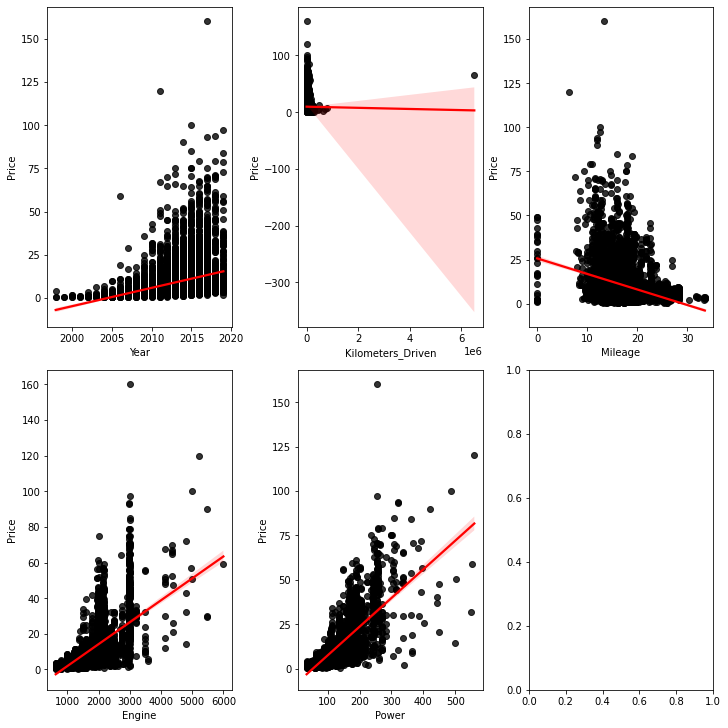

In [183]:
# 이상치 존재 확인 (Kilometers_Driven의 경우 시각적으로 확인이 가능)
num_cols = df.iloc[:,:-1].select_dtypes(include=['int64','float64']).columns.tolist() 
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10,10),constrained_layout=True)
for n,col in enumerate(num_cols):
    ax = axs[n // 3, n % 3]
    sns.regplot(x=col,y="Price",data=df,ax=ax,fit_reg = True,scatter_kws={"color": "black"}, line_kws={"color": "red"});

- 이상치 제거

In [184]:
def outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    cut_off = iqr * 1.5
    lower, upper = q1 - cut_off, q3 + cut_off 
    return df[(df[col] < lower)|(df[col] > upper)]

In [185]:
# 수치형 변수에 대한 이상치 탐색
remove_col=[]
print("컬럼별 이상치 개수")
for i in num_cols:
    print(i,":",outlier(df,i).shape[0]) #열별 이상치 개수 합
    if outlier(df,i).shape[0]>0:
        remove_col.append(i)

컬럼별 이상치 개수
Year : 105
Kilometers_Driven : 199
Mileage : 43
Engine : 58
Power : 238


In [186]:
# 이상치 제거 함수
def remove(df,col):
    for i in col:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3 - q1
        cut_off = iqr * 1.5
        lower, upper = q1 - cut_off, q3 + cut_off 
        df=df[(df[i]>lower)&(df[i]<upper)]
        df=df.reset_index(drop=True)
    return df    

In [187]:
df=remove(df,remove_col) #이상치 포함 행 제거
df # 약 600개 행 제거

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
...,...,...,...,...,...,...,...,...,...,...,...,...
5221,Maruti,Delhi,2014,27365,Diesel,Manual,First,28.40,1248.0,74.00,5.0,4.75
5222,Hyundai,Jaipur,2015,100000,Diesel,Manual,First,24.40,1120.0,71.00,5.0,4.00
5223,Mahindra,Jaipur,2012,55000,Diesel,Manual,Second,14.00,2498.0,112.00,8.0,2.90
5224,Maruti,Kolkata,2013,46000,Petrol,Manual,First,18.90,998.0,67.10,5.0,2.65


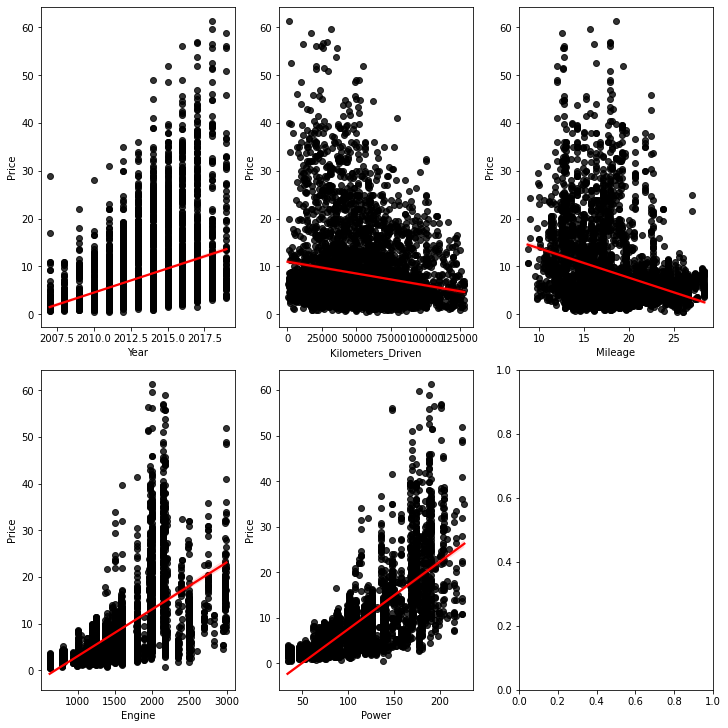

In [188]:
# 이상치 제거 확인
num_cols = df.iloc[:,:-1].select_dtypes(include=['int64','float64']).columns.tolist() 
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10,10),constrained_layout=True)
for n,col in enumerate(num_cols):
    ax = axs[n // 3, n % 3]
    sns.regplot(x=col,y="Price",data=df,ax=ax,scatter_kws={"color": "black"}, line_kws={"color": "red"});

#### 범주형 설명변수 분포 확인 

In [189]:
# Name
print(df['Name'].value_counts(),'\n')
# Location
print(df['Location'].value_counts(),'\n')
# Fuel_Type
print(df['Fuel_Type'].value_counts(),'\n')
# Transmission
print(df['Transmission'].value_counts(),'\n')
# Owner Type
print(df['Owner_Type'].value_counts(),'\n')
# Seats
print(df['Seats'].value_counts(),'\n')

Maruti           1083
Hyundai          1017
Honda             571
Toyota            320
Volkswagen        308
Ford              250
Mahindra          244
Mercedes-Benz     243
BMW               184
Audi              173
Tata              162
Skoda             154
Renault           139
Chevrolet         114
Nissan             86
Land               39
Mini               26
Jaguar             20
Volvo              20
Mitsubishi         20
Fiat               19
Jeep               15
Datsun             13
Force               3
ISUZU               2
Isuzu               1
Name: Name, dtype: int64 

Mumbai        709
Hyderabad     618
Kochi         608
Coimbatore    560
Delhi         509
Pune          503
Kolkata       489
Chennai       376
Jaipur        348
Bangalore     296
Ahmedabad     210
Name: Location, dtype: int64 

Diesel    2719
Petrol    2456
CNG         41
LPG         10
Name: Fuel_Type, dtype: int64 

Manual       3836
Automatic    1390
Name: Transmission, dtype: int64 

First    

In [190]:
# Name 'Force','ISUZU','Isuzu' 이상치로 판단, 제거
df=df[df['Name'].isin(['Force','ISUZU','Isuzu'])==False]
# Fuel_type : 'LPG' 'Electric' 이상치로 판단, 제거
df=df[df['Fuel_Type'].isin(['Diesel','Petrol','CNG'])]
# Owner_Type: 'Fourth & Above' 이상치로 판단, 제거
df=df[df['Owner_Type'].isin(['First','Second','Third'])]
# Seats: '2','9','10' 이상치로 판단, 제거
df=df[df['Seats'].isin([2.0,9.0,10.0])==False]

In [191]:
# 범주형변수 더미변수 생성
Name = pd.get_dummies(df[['Name']],drop_first=True)
Location = pd.get_dummies(df[['Location']],drop_first=True)
FuelType = pd.get_dummies(df[['Fuel_Type']],drop_first=True)
Transmission = pd.get_dummies(df[['Transmission']],drop_first=True)

df.replace({"First":1,"Second":2,"Third":3,"Fourth & Above":4},inplace=True)

df=pd.concat([df,Name,Location,FuelType,Transmission],axis=1)
df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,...,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
0,Maruti,Mumbai,2010,72000,CNG,Manual,1,26.60,998.0,58.16,...,0,0,0,0,0,1,0,0,0,1
1,Hyundai,Pune,2015,41000,Diesel,Manual,1,19.67,1582.0,126.20,...,0,0,0,0,0,0,1,1,0,1
2,Honda,Chennai,2011,46000,Petrol,Manual,1,18.20,1199.0,88.70,...,0,0,0,0,0,0,0,0,1,1
3,Maruti,Chennai,2012,87000,Diesel,Manual,1,20.77,1248.0,88.76,...,0,0,0,0,0,0,0,1,0,1
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,2,15.20,1968.0,140.80,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,Maruti,Delhi,2014,27365,Diesel,Manual,1,28.40,1248.0,74.00,...,1,0,0,0,0,0,0,1,0,1
5222,Hyundai,Jaipur,2015,100000,Diesel,Manual,1,24.40,1120.0,71.00,...,0,0,1,0,0,0,0,1,0,1
5223,Mahindra,Jaipur,2012,55000,Diesel,Manual,2,14.00,2498.0,112.00,...,0,0,1,0,0,0,0,1,0,1
5224,Maruti,Kolkata,2013,46000,Petrol,Manual,1,18.90,998.0,67.10,...,0,0,0,0,1,0,0,0,1,1


In [192]:
df.drop(["Name","Location","Fuel_Type","Transmission"],axis=1,inplace=True)
df

,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Name_BMW,Name_Chevrolet,...,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
0,2010,72000,1,26.60,998.0,58.16,5.0,1.75,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2015,41000,1,19.67,1582.0,126.20,5.0,12.50,0,0,...,0,0,0,0,0,0,1,1,0,1
2,2011,46000,1,18.20,1199.0,88.70,5.0,4.50,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2012,87000,1,20.77,1248.0,88.76,7.0,6.00,0,0,...,0,0,0,0,0,0,0,1,0,1
4,2013,40670,2,15.20,1968.0,140.80,5.0,17.74,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,2014,27365,1,28.40,1248.0,74.00,5.0,4.75,0,0,...,1,0,0,0,0,0,0,1,0,1
5222,2015,100000,1,24.40,1120.0,71.00,5.0,4.00,0,0,...,0,0,1,0,0,0,0,1,0,1
5223,2012,55000,2,14.00,2498.0,112.00,8.0,2.90,0,0,...,0,0,1,0,0,0,0,1,0,1
5224,2013,46000,1,18.90,998.0,67.10,5.0,2.65,0,0,...,0,0,0,0,1,0,0,0,1,1


---

### 모델 적합 (회귀 분석)

In [219]:
y=df["Price"]
X=df[df.columns.difference(['Price'])]

In [221]:
# 상수행 B0 추가
X=sm.add_constant(X) 

# 회귀 모델 적합
model=sm.OLS(y,X)
model_trained=model.fit()

# 결과 출력
model_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     598.2
Date:                Tue, 31 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:30:56   Log-Likelihood:                -13640.
No. Observations:                5199   AIC:                         2.737e+04
Df Residuals:                    5156   BIC:                         2.765e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1631.7779     49.565    -32.922      0.000   -1728.947   -1534.609
Engine              -1.125e-05      0.000     -0.036      0.971      -0.001       0.001
Fuel_Type_Diesel        0.6837      0.540      1.267      0.205      -0.374       1.741
Fuel_Type_Petrol       -0.9458      0.543     -1.741      0.082      -2.011       0.119
Kilometers_Driven   -2.768e-05   2.46e-06    -11.260      0.000   -3.25e-05   -2.29e-05
Location_Bangalore      1.6177      0.305      5.297      0.000       1.019       2.217
Location_Chennai        0.4584      0.291      1.574      0.116      -0.113       1.030
Location_Coimbatore     1.4678      0.276      5.323      0.000       0.927       2.008
Location_Delhi         -0.6206      0.276     -2.248      0.025      -1.162      -0.079
Location_Hyderabad      1.4096      0.270      5.223      0.000       0.881       1.939
Location_Jaipur         0.5099      0.296      1.724      0.085      -0.070       1.090
Location_Kochi         -0.2695      0.273     -0.987      0.324      -0.805       0.266
Location_Kolkata       -1.3827      0.280     -4.936      0.000      -1.932      -0.834
Location_Mumbai        -0.5863      0.267     -2.198      0.028      -1.109      -0.063
Location_Pune           0.3250      0.278      1.170      0.242      -0.219       0.869
Mileage                -0.0887      0.025     -3.617      0.000      -0.137      -0.041
Name_BMW               -1.7119      0.366     -4.675      0.000      -2.430      -0.994
Name_Chevrolet         -9.8540      0.452    -21.799      0.000     -10.740      -8.968
Name_Datsun           -11.8558      1.006    -11.791      0.000     -13.827      -9.885
Name_Fiat             -10.0606      0.834    -12.063      0.000     -11.696      -8.426
Name_Ford              -9.1506      0.385    -23.768      0.000      -9.905      -8.396
Name_Honda             -9.6994      0.345    -28.122      0.000     -10.376      -9.023
Name_Hyundai           -9.4208      0.335    -28.087      0.000     -10.078      -8.763
Name_Jaguar             9.2368      0.795     11.616      0.000       7.678      10.796
Name_Jeep              -6.3477      0.919     -6.909      0.000      -8.149      -4.546
Name_Land              10.6522      0.601     17.719      0.000       9.474      11.831
Name_Mahindra         -11.0048      0.423    -25.988      0.000     -11.835     -10.175
Name_Maruti            -8.9442      0.356    -25.148      0.000      -9.641      -8.247
Name_Mercedes-Benz      1.3957      0.339      4.120      0.000       0.732       2.060
Name_Mini               6.1691      0.713      8.654      0.000       4.772       7.567
Name_Mitsubishi        -6.8276      0.825     -8.275      0.000      -8.445      -5.210
Name_Nissan            -9.2133      0.484    -19.027      0.000     -10.163      -8.264
Nam

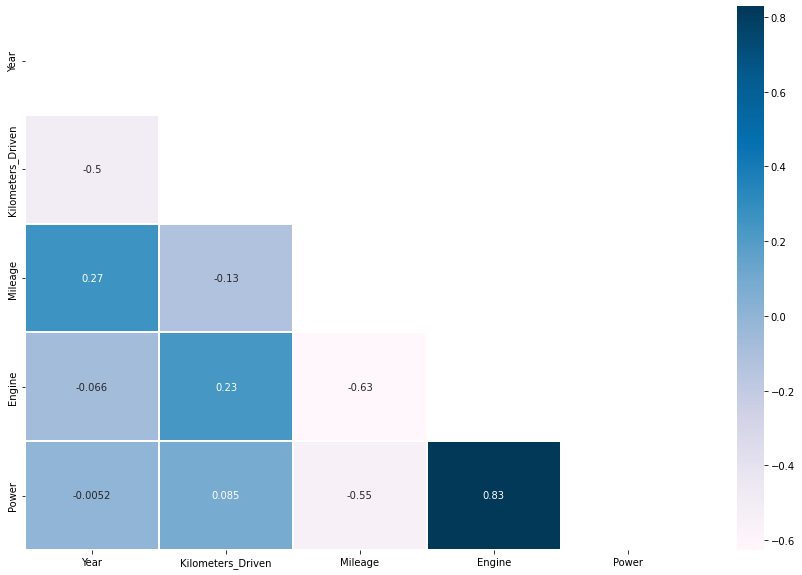

In [222]:
heatmap_data = X[num_cols].corr() 
colormap = plt.cm.PuBu

mask = np.zeros_like(heatmap_data, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (15,10))
sns.heatmap(data = heatmap_data, mask=mask,annot = True,linewidths=.1, cmap = colormap)
plt.show()

---

### 회귀 진단
#### 다중공선성 확인

In [223]:
X=df[df.columns.difference(['Price'])]

In [224]:
# VIF 분산 팽창 요인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
41,617.369144,Year
39,147.187200,Seats
0,115.871003,Engine
14,95.526580,Mileage
1,70.223544,Fuel_Type_Diesel
2,64.425207,Fuel_Type_Petrol
38,58.416030,Power
26,12.104025,Name_Maruti
37,10.616198,Owner_Type
21,10.088887,Name_Hyundai


In [225]:
# Engine 변수 제거 (Power와 상관관계가 높았으므로 우선적으로 제거)
vif = pd.DataFrame()
X1 = X.drop("Engine",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif["features"] = X1.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
40,578.130112,Year
38,140.292577,Seats
13,80.046258,Mileage
0,70.014293,Fuel_Type_Diesel
1,63.846216,Fuel_Type_Petrol
37,35.129259,Power
25,12.068950,Name_Maruti
36,10.609736,Owner_Type
20,10.045638,Name_Hyundai
39,7.804705,Transmission_Manual


In [226]:
# Seats 변수 제거
vif = pd.DataFrame()
X2 = X1.drop("Seats",axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
39,381.196563,Year
0,69.953803,Fuel_Type_Diesel
13,68.164421,Mileage
1,63.479056,Fuel_Type_Petrol
37,35.126832,Power
25,11.383255,Name_Maruti
36,10.578864,Owner_Type
20,9.756808,Name_Hyundai
38,7.769625,Transmission_Manual
2,7.171464,Kilometers_Driven


In [227]:
# Fuel_Type 변수 제거 (Year와 상관관계가 있었다고 추정)
vif = pd.DataFrame()
X3 = X2.drop(["Fuel_Type_Diesel","Fuel_Type_Petrol"],axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif["features"] = X3.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
37,194.148153,Year
11,43.056786,Mileage
35,28.737583,Power
23,11.109372,Name_Maruti
34,10.553438,Owner_Type
18,9.521076,Name_Hyundai
36,7.719367,Transmission_Manual
0,6.482516,Kilometers_Driven
17,5.419638,Name_Honda
9,4.468281,Location_Mumbai


In [228]:
# Year 변수 제거 (중요한 변수이나 여전히 VIF 값이 너무 크므로 제거)
vif = pd.DataFrame()
X4 = X3.drop(["Year"],axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X4.values, i) for i in range(X4.shape[1])]
vif["features"] = X4.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
11,25.962106,Mileage
35,15.008448,Power
34,9.845688,Owner_Type
23,8.126510,Name_Maruti
36,7.645204,Transmission_Manual
18,6.844825,Name_Hyundai
0,6.446913,Kilometers_Driven
17,4.197115,Name_Honda
9,3.931486,Location_Mumbai
5,3.550631,Location_Hyderabad


In [230]:
# 상수행 B0 추가
X4=sm.add_constant(X4) 

#회귀 모델 적합
model=sm.OLS(y,X4)
model_trained=model.fit()

# 결과 출력 (OLS)
model_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     495.1
Date:                Tue, 31 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:31:20   Log-Likelihood:                -14304.
No. Observations:                5199   AIC:                         2.868e+04
Df Residuals:                    5161   BIC:                         2.893e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.0200      0.734      6.844      0.000       3.582       6.458
Kilometers_Driven   -5.821e-05    2.3e-06    -25.271      0.000   -6.27e-05   -5.37e-05
Location_Bangalore      1.6960      0.347      4.891      0.000       1.016       2.376
Location_Chennai        0.3561      0.331      1.077      0.282      -0.292       1.004
Location_Coimbatore     2.6267      0.310      8.482      0.000       2.020       3.234
Location_Delhi         -0.7018      0.313     -2.241      0.025      -1.316      -0.088
Location_Hyderabad      1.5346      0.306      5.009      0.000       0.934       2.135
Location_Jaipur         0.9197      0.335      2.743      0.006       0.262       1.577
Location_Kochi          0.7998      0.306      2.610      0.009       0.199       1.401
Location_Kolkata       -2.1370      0.317     -6.738      0.000      -2.759      -1.515
Location_Mumbai        -0.8427      0.302     -2.787      0.005      -1.436      -0.250
Location_Pune           0.4177      0.315      1.326      0.185      -0.200       1.035
Mileage                 0.2509      0.018     13.945      0.000       0.216       0.286
Name_BMW               -3.1515      0.411     -7.669      0.000      -3.957      -2.346
Name_Chevrolet         -9.8520      0.507    -19.439      0.000     -10.846      -8.858
Name_Datsun           -10.0720      1.127     -8.939      0.000     -12.281      -7.863
Name_Fiat              -9.1041      0.946     -9.624      0.000     -10.959      -7.250
Name_Ford              -7.7623      0.429    -18.087      0.000      -8.604      -6.921
Name_Honda             -9.7577      0.370    -26.339      0.000     -10.484      -9.031
Name_Hyundai           -8.8258      0.369    -23.923      0.000      -9.549      -8.103
Name_Jaguar             9.2138      0.903     10.206      0.000       7.444      10.984
Name_Jeep              -4.2334      1.040     -4.069      0.000      -6.273      -2.194
Name_Land              13.0217      0.678     19.193      0.000      11.692      14.352
Name_Mahindra          -7.1414      0.416    -17.170      0.000      -7.957      -6.326
Name_Maruti            -8.2666      0.386    -21.399      0.000      -9.024      -7.509
Name_Mercedes-Benz      1.3629      0.382      3.572      0.000       0.615       2.111
Name_Mini               5.3297      0.806      6.615      0.000       3.750       6.909
Name_Mitsubishi        -4.5907      0.912     -5.035      0.000      -6.378      -2.803
Name_Nissan            -8.1122      0.543    -14.932      0.000      -9.177      -7.047
Name_Renault           -8.4789      0.480    -17.660      0.000      -9.420      -7.538
Name_Skoda             -8.6571      0.438    -19.750      0.000      -9.516      -7.798
Name_Tata              -9.1793      0.472    -19.464      0.000     -10.104      -8.255
Nam

condition number가  1.84e+06 로 훨씬 낮아져 조금은 완화됐으나<br>
많은 변수를 제거하여 모형의 설명력이 78%로 낮아졌고 다중공선성이 여전히 존재한다

####  독립성 판단 <br>
위에서 더빈왓슨검정(DW검정)의 값이 1.984이므로 2미만의 값으로<br>잔차들이 독립성을 만족한다고 판단할 수 있다

In [231]:
# train test 분할
from sklearn.model_selection import train_test_split
X_final=X4
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=0)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(4159, 38) (1040, 38) (4159,) (1040,)


In [240]:
model = sm.OLS(y_train,X_train)
fit_train = model.fit()

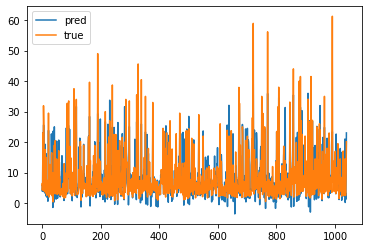

In [241]:
plt.plot(np.array(fit_train.predict(X_test)),label = "pred")
plt.plot(np.array(y_test),label = "true")
plt.legend()
plt.show()

####  정규성 판단

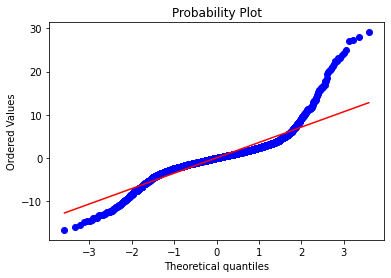

In [242]:
# 잔차
resid= fit_train.resid

from scipy.stats import probplot
# Q-Q plot
plt.figure()
probplot(resid, plot=plt)
plt.show()

In [243]:
#shapiro-wilk test
from scipy import stats
stats.shapiro(resid)

ShapiroResult(statistic=0.8651396036148071, pvalue=0.0)

정규성을 만족하지 못한다 : 정규화 과정 필요

#### 등분산성 판단

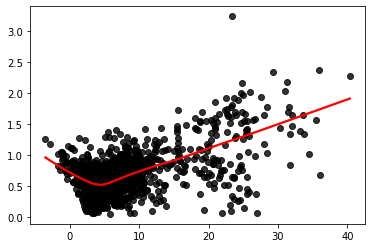

In [255]:
import scipy.stats
fitted=fit_train.predict(X_test)
resid=y_test-fitted
sr=scipy.stats.zscore(resid)
sns.regplot(x=fitted,y=np.sqrt(np.abs(sr)),lowess=True,scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.show()

실선이 수평선에 가까울 수록 등분산성이 존재한다고 볼 수 있으나 <br>위와 같은 그래프를 통해 잔차가 등분산성을 만족하지 않으므로 <br>이를 만족시키기 위한 과정이 필요함을 알 수 있음